# Segmentation Training


In [1]:
import yaml
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam

# Mount drive and change working directory (only for collab)
from google.colab import drive
drive.mount('/content/drive')
project_folder_path = '/content/drive/MyDrive/CoVision'
os.chdir(project_folder_path)

# Custom packages
from utils_segmentation.visualization import show_images, plot_metrics
from utils_segmentation.utils_dataset import split_files_train_test, build_target_from_mask, load_valid_filepaths
from utils_segmentation.utils import collate_fn, compute_iou_mask, compute_iou_box
from dataset_segmentation import LFASegmentationDataset
from transformations_segmentation import TransformationSegmentationTraining, resize_image
from model_segmentation import get_segmentation_model
from training_segmentation import TrainingSegmentation
from inference_segmentation import predict_testset

Mounted at /content/drive


## Parameters

In [2]:
# Read the configuration file
cwd = '.'  # Current working directory (must be changed in collab)
cwd = os.getcwd()
with open('config_segmentation.yaml', 'r') as f:
    config = yaml.safe_load(f)
config['DataSettings']['data_dir'] = os.path.join(cwd, config['DataSettings']['data_dir'])
config['DataSettings']['output_dir'] = os.path.join(cwd, config['DataSettings']['output_dir'])
config['TrainingParameters']['save_path'] = os.path.join(cwd, config['TrainingParameters']['save_path'])
data_settings = config['DataSettings']
transformation_parameters = config['TransformationParameters']
training_parameters = config['TrainingParameters']

print(data_settings)
print(transformation_parameters)
print(training_parameters)

{'data_dir': '/content/drive/MyDrive/CoVision/data_segmentation', 'output_dir': '/content/drive/MyDrive/CoVision/output', 'split_ratio': 0.8, 'background_id': 0, 'background_color': [255, 0, 0], 'classes': ['kit', 'membrane'], 'class_ids': [1, 2], 'class_colors': [[0, 0, 255], [0, 255, 0]], 'resize_height': 800}
{'rotate_limit': 80, 'rotate_p': 0.8, 'horizontal_flip_p': 0.5, 'blur_limit': 5, 'blur_p': 0.8, 'color_jitter_brightness': 0.1, 'color_jitter_contrast': 0.1, 'color_jitter_saturation': 0.1, 'color_jitter_p': 0.5}
{'save_path': '/content/drive/MyDrive/CoVision/saved_models', 'train_validation_ratio': 0.8, 'num_workers': 0, 'batch_size': 4, 'seed': 42, 'num_epochs': 10, 'num_classes': 3, 'hidden_size': 256, 'learning_rate': '5e-5', 'score_thresholds': [0.85, 0.85], 'mask_thresholds': [0.85, 0.85]}


## Training

In [3]:
config['TrainingParameters']['num_epochs'] = 50
config['TrainingParameters']['num_workers'] = 2
config['TrainingParameters']['batch_size'] = 8
config['TrainingParameters']['train_validation_ratio'] = 0.80
config['TrainingParameters']['mask_thresholds'] = [0.7, 0.7]
config['TrainingParameters']['learning_rate'] = 1e-4

transformation_train = TransformationSegmentationTraining(transformation_parameters)

training_app = TrainingSegmentation(config_file=config, kit_id='btnx',
                                    transformation_train=transformation_train,
                                    transformation_val=None)

Using cuda device
Random seed set as 42
Loading data...
Loaded 52 image and mask paths!
Loaded 14 image and mask paths!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 154MB/s]


In [4]:
training_app.main(save_bool=True)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1: lr 0.0001 -> 9.5e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2: lr 9.5e-05 -> 9.025e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3: lr 9.025e-05 -> 8.573749999999999e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4: lr 8.573749999999999e-05 -> 8.145062499999998e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5: lr 8.145062499999998e-05 -> 7.737809374999998e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6: lr 7.737809374999998e-05 -> 7.350918906249998e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7: lr 7.350918906249998e-05 -> 6.983372960937497e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8: lr 6.983372960937497e-05 -> 6.634204312890622e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9: lr 6.634204312890622e-05 -> 6.30249409724609e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10: lr 6.30249409724609e-05 -> 5.987369392383786e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11: lr 5.987369392383786e-05 -> 5.688000922764596e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12: lr 5.688000922764596e-05 -> 5.4036008766263664e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13: lr 5.4036008766263664e-05 -> 5.133420832795048e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14: lr 5.133420832795048e-05 -> 4.876749791155295e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15: lr 4.876749791155295e-05 -> 4.6329123015975305e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16: lr 4.6329123015975305e-05 -> 4.4012666865176535e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17: lr 4.4012666865176535e-05 -> 4.181203352191771e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18: lr 4.181203352191771e-05 -> 3.972143184582182e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19: lr 3.972143184582182e-05 -> 3.7735360253530726e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20: lr 3.7735360253530726e-05 -> 3.584859224085419e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21: lr 3.584859224085419e-05 -> 3.405616262881148e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22: lr 3.405616262881148e-05 -> 3.2353354497370904e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23: lr 3.2353354497370904e-05 -> 3.0735686772502355e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24: lr 3.0735686772502355e-05 -> 2.9198902433877236e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25: lr 2.9198902433877236e-05 -> 2.7738957312183373e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26: lr 2.7738957312183373e-05 -> 2.6352009446574204e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27: lr 2.6352009446574204e-05 -> 2.5034408974245492e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28: lr 2.5034408974245492e-05 -> 2.3782688525533216e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29: lr 2.3782688525533216e-05 -> 2.2593554099256555e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30: lr 2.2593554099256555e-05 -> 2.1463876394293726e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31: lr 2.1463876394293726e-05 -> 2.039068257457904e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32: lr 2.039068257457904e-05 -> 1.9371148445850086e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33: lr 1.9371148445850086e-05 -> 1.840259102355758e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34: lr 1.840259102355758e-05 -> 1.74824614723797e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35: lr 1.74824614723797e-05 -> 1.6608338398760715e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36: lr 1.6608338398760715e-05 -> 1.5777921478822678e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37: lr 1.5777921478822678e-05 -> 1.4989025404881544e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38: lr 1.4989025404881544e-05 -> 1.4239574134637466e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39: lr 1.4239574134637466e-05 -> 1.3527595427905592e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40: lr 1.3527595427905592e-05 -> 1.2851215656510312e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41: lr 1.2851215656510312e-05 -> 1.2208654873684796e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42: lr 1.2208654873684796e-05 -> 1.1598222130000555e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43: lr 1.1598222130000555e-05 -> 1.1018311023500527e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44: lr 1.1018311023500527e-05 -> 1.04673954723255e-05


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45: lr 1.04673954723255e-05 -> 9.944025698709225e-06


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46: lr 9.944025698709225e-06 -> 9.446824413773763e-06


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47: lr 9.446824413773763e-06 -> 8.974483193085074e-06


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48: lr 8.974483193085074e-06 -> 8.52575903343082e-06


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49: lr 8.52575903343082e-06 -> 8.09947108175928e-06


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50: lr 8.09947108175928e-06 -> 7.694497527671315e-06


  0%|          | 0/2 [00:00<?, ?it/s]

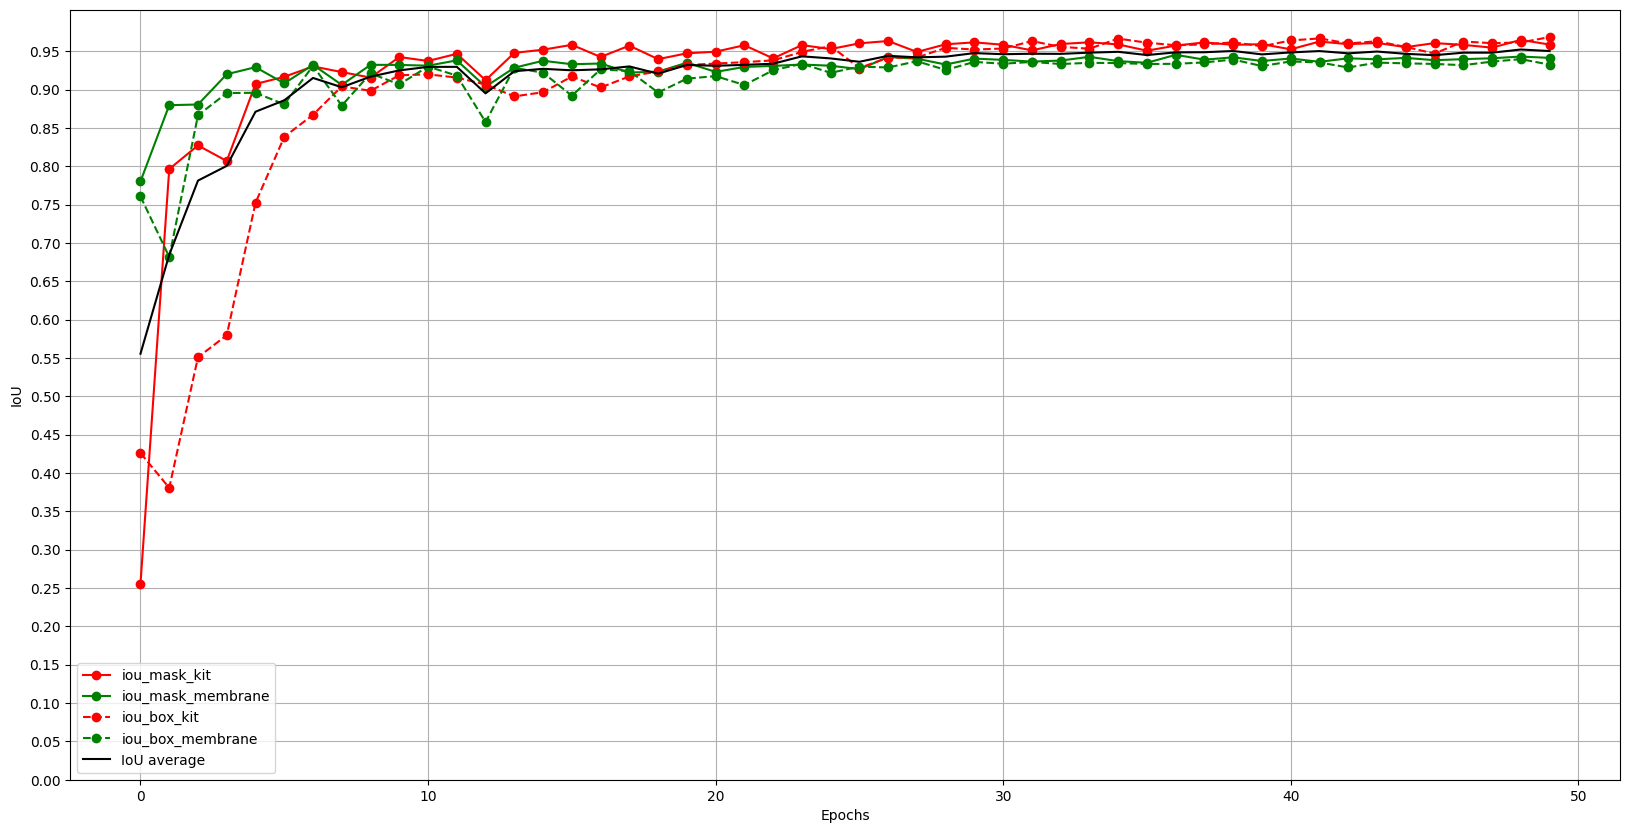

In [5]:
metrics_train_df, metrics_val_df = training_app.get_metrics()
plot_metrics(metrics_val_df)

In [ ]:
# load_path = '/content/drive/MyDrive/CoVision/saved_models/2024-02-02_11.51.49_best.state'
# training_app.load_state(load_path, device='cuda')

In [6]:
images_test, predictions_test, metrics_test, metrics_test_df = predict_testset(kit_id='btnx',
                                                               config_file=config,
                                                               model=training_app.model,
                                                               save_filename=training_app.stamp,
                                                               show_bool=True)

Output hidden; open in https://colab.research.google.com to view.